In [ ]:
!ls
!which python
!nvidia-smi

logs  resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  run.ipynb
/lyceum/oew1g21/.conda/envs/schigand/bin/python
Thu May  1 05:42:11 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:02:00.0 Off |                  N/A |
| 23%   27C    P8               8W / 250W |      0MiB / 11264MiB |      0%      Default |
|                                       

In [ ]:
dataset_path = "/scratch/oew1g21/mri_images"
!ls {dataset_path}

Testing  Training


In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /mainfs/lyceum/oew1g21/.conda/envs/schigand/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [ ]:
import os
#os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
#os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/lyceum/oew1g21/.conda/envs/schigand"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=" + os.environ["CONDA_PREFIX"]


import tensorflow as tf

# Now try to use TensorFlow with GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print("Using CUDA from:", os.environ["CONDA_PREFIX"])
print("XLA_FLAGS:", os.environ.get("XLA_FLAGS", "Not set"))

2025-05-01 05:42:43.728364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 05:42:43.728428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 05:42:43.730191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 05:42:43.741608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-01 05:42:58.591472: W tensorflow/compiler/tf2

Num GPUs Available:  2
Using CUDA from: /lyceum/oew1g21/.conda/envs/schigand
XLA_FLAGS: --xla_gpu_cuda_data_dir=/lyceum/oew1g21/.conda/envs/schigand


# Importing Libraries

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime
import imutils

import cv2
import os
import io

2025-05-01 11:15:05.802294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 11:15:05.802398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 11:15:05.962556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 11:15:06.107863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-01 11:15:24.275167: W tensorflow/compiler/tf2

In [ ]:
def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if not cnts:
        return img  # fallback: return original image if no contour found

    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = 0
    cropped = img[max(extTop[1]-ADD_PIXELS, 0):extBot[1]+ADD_PIXELS,
                  max(extLeft[0]-ADD_PIXELS, 0):extRight[0]+ADD_PIXELS].copy()

    return cropped


labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200

for label in labels:
    trainPath = os.path.join('/scratch/oew1g21/mri_images/Training', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # shape: (H, W, 3)
        image = crop_img(image)
        image = cv2.resize(image, (image_size, image_size))
        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join('/scratch/oew1g21/mri_images/Testing', label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = crop_img(image)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train, dtype=np.float32) / 255.0
x_test = np.array(x_test, dtype=np.float32) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|█████████████████████████████████████████| 300/300 [00:05<00:00, 54.42it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


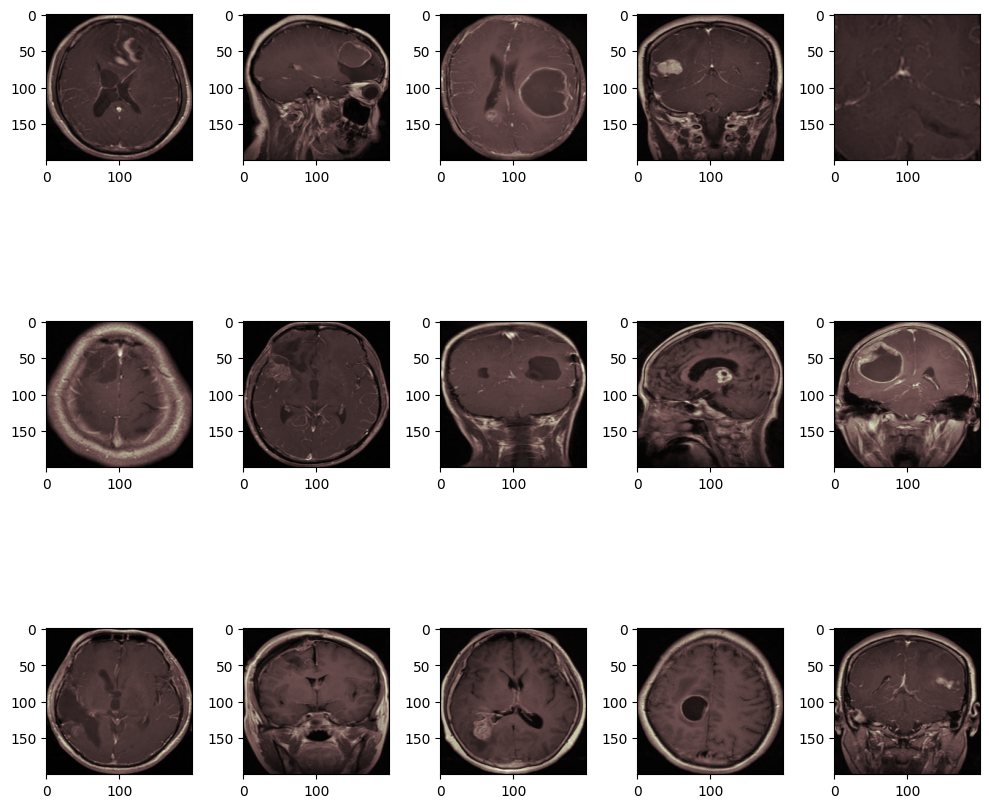

In [ ]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


# Data Augmentation

In [ ]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

# Pretrained Model

In [ ]:
!ls

logs  resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  run.ipynb


In [ ]:
net = ResNet50(
    weights='resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

2025-05-01 05:47:18.298468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2025-05-01 05:47:18.299027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10534 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


In [ ]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
#%load_ext tensorboard


class_names = list(labels)
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image.
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder
!rm -fr logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Run tensorBoard
#%tensorboard --logdir logs

In [ ]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)


Epoch 1/50


2025-05-01 05:47:53.095716: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-05-01 05:47:57.527616: I external/local_xla/xla/service/service.cc:168] XLA service 0x2b411536ab90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-01 05:47:57.527657: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-01 05:47:57.527669: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-01 05:47:57.537724: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746074877.774908   28469 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


229/229 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.8921
Epoch 1: val_loss improved from inf to 6.57601, saving model to model-01-0.23-6.58.h5


/lyceum/oew1g21/.conda/envs/schigand/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 98s 260ms/step - loss: 0.3105 - accuracy: 0.8921 - val_loss: 6.5760 - val_accuracy: 0.2336 - lr: 1.0000e-04
Epoch 2/50
229/229 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9595
Epoch 2: val_loss improved from 6.57601 to 3.80837, saving model to model-02-0.24-3.81.h5


/lyceum/oew1g21/.conda/envs/schigand/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 51s 223ms/step - loss: 0.1218 - accuracy: 0.9595 - val_loss: 3.8084 - val_accuracy: 0.2362 - lr: 1.0000e-04
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9705
Epoch 3: val_loss did not improve from 3.80837
229/229 [==============================] - 50s 220ms/step - loss: 0.0966 - accuracy: 0.9705 - val_loss: 4.1701 - val_accuracy: 0.3036 - lr: 1.0000e-04
Epoch 4/50
229/229 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9775
Epoch 4: val_loss improved from 3.80837 to 1.04203, saving model to model-04-0.76-1.04.h5


/lyceum/oew1g21/.conda/envs/schigand/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 52s 225ms/step - loss: 0.0689 - accuracy: 0.9775 - val_loss: 1.0420 - val_accuracy: 0.7612 - lr: 1.0000e-04
Epoch 5/50
229/229 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9840
Epoch 5: val_loss improved from 1.04203 to 0.07635, saving model to model-05-0.97-0.08.h5


/lyceum/oew1g21/.conda/envs/schigand/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 51s 224ms/step - loss: 0.0490 - accuracy: 0.9840 - val_loss: 0.0764 - val_accuracy: 0.9711 - lr: 1.0000e-04
Epoch 6/50
229/229 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9805
Epoch 6: val_loss did not improve from 0.07635
229/229 [==============================] - 50s 219ms/step - loss: 0.0594 - accuracy: 0.9805 - val_loss: 0.1154 - val_accuracy: 0.9615 - lr: 1.0000e-04
Epoch 7/50
229/229 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9875
Epoch 7: val_loss improved from 0.07635 to 0.05794, saving model to model-07-0.98-0.06.h5


/lyceum/oew1g21/.conda/envs/schigand/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 51s 223ms/step - loss: 0.0354 - accuracy: 0.9875 - val_loss: 0.0579 - val_accuracy: 0.9764 - lr: 1.0000e-04
Epoch 8/50
229/229 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9886
Epoch 8: val_loss did not improve from 0.05794
229/229 [==============================] - 50s 220ms/step - loss: 0.0392 - accuracy: 0.9886 - val_loss: 0.1176 - val_accuracy: 0.9668 - lr: 1.0000e-04
Epoch 9/50
229/229 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9862
Epoch 9: val_loss did not improve from 0.05794
229/229 [==============================] - 51s 224ms/step - loss: 0.0524 - accuracy: 0.9862 - val_loss: 0.2671 - val_accuracy: 0.9326 - lr: 1.0000e-04
Epoch 10/50
229/229 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9923
Epoch 10: val_loss improved from 0.05794 to 0.04746, saving model to model-10-0.99-0.05.h5


/lyceum/oew1g21/.conda/envs/schigand/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 51s 223ms/step - loss: 0.0297 - accuracy: 0.9923 - val_loss: 0.0475 - val_accuracy: 0.9860 - lr: 1.0000e-04
Epoch 11/50
229/229 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9893
Epoch 11: val_loss did not improve from 0.04746
229/229 [==============================] - 50s 220ms/step - loss: 0.0330 - accuracy: 0.9893 - val_loss: 0.3889 - val_accuracy: 0.8854 - lr: 1.0000e-04
Epoch 12/50
229/229 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9899
Epoch 12: val_loss did not improve from 0.04746
229/229 [==============================] - 50s 220ms/step - loss: 0.0342 - accuracy: 0.9899 - val_loss: 0.1854 - val_accuracy: 0.9545 - lr: 1.0000e-04
Epoch 13/50
229/229 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9917
Epoch 13: val_loss did not improve from 0.04746
229/229 [==============================] - 50s 220ms/step - loss: 0.0285 - accuracy: 0.9917 - val_loss: 0.1544 -

/lyceum/oew1g21/.conda/envs/schigand/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 51s 224ms/step - loss: 0.0229 - accuracy: 0.9939 - val_loss: 0.0448 - val_accuracy: 0.9878 - lr: 1.0000e-04
Epoch 16/50
229/229 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9945
Epoch 16: val_loss did not improve from 0.04484
229/229 [==============================] - 51s 221ms/step - loss: 0.0138 - accuracy: 0.9945 - val_loss: 0.0757 - val_accuracy: 0.9825 - lr: 1.0000e-04
Epoch 17/50
229/229 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9926
Epoch 17: val_loss did not improve from 0.04484
229/229 [==============================] - 50s 220ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.0595 - val_accuracy: 0.9834 - lr: 1.0000e-04
Epoch 18/50
229/229 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 0.9928
Epoch 18: val_loss did not improve from 0.04484
229/229 [==============================] - 51s 221ms/step - loss: 0.0233 - accuracy: 0.9928 - val_loss: 0.2676 -

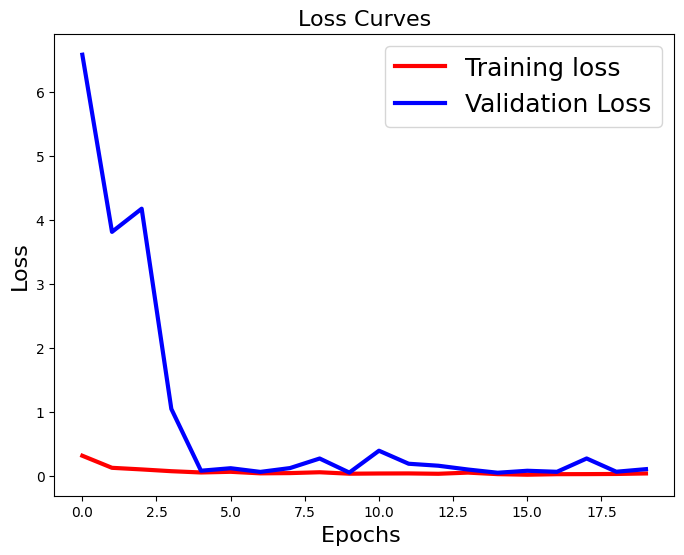

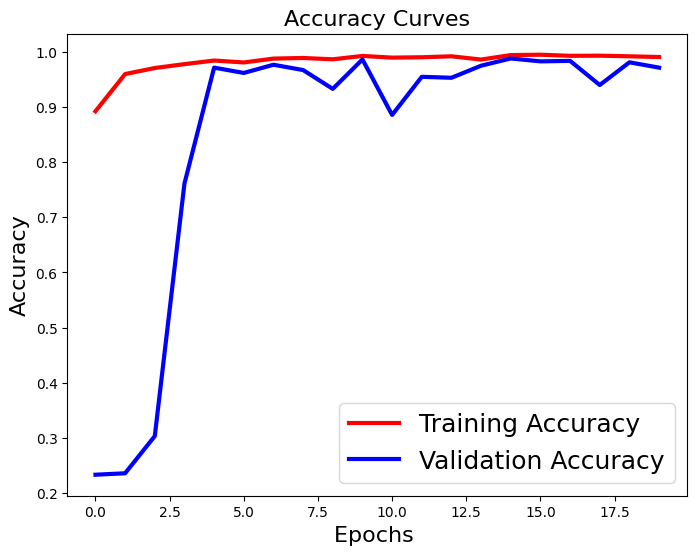

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

41/41 [==============================] - 2s 46ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       300
           1       0.98      0.99      0.99       306
           2       1.00      0.99      1.00       405
           3       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



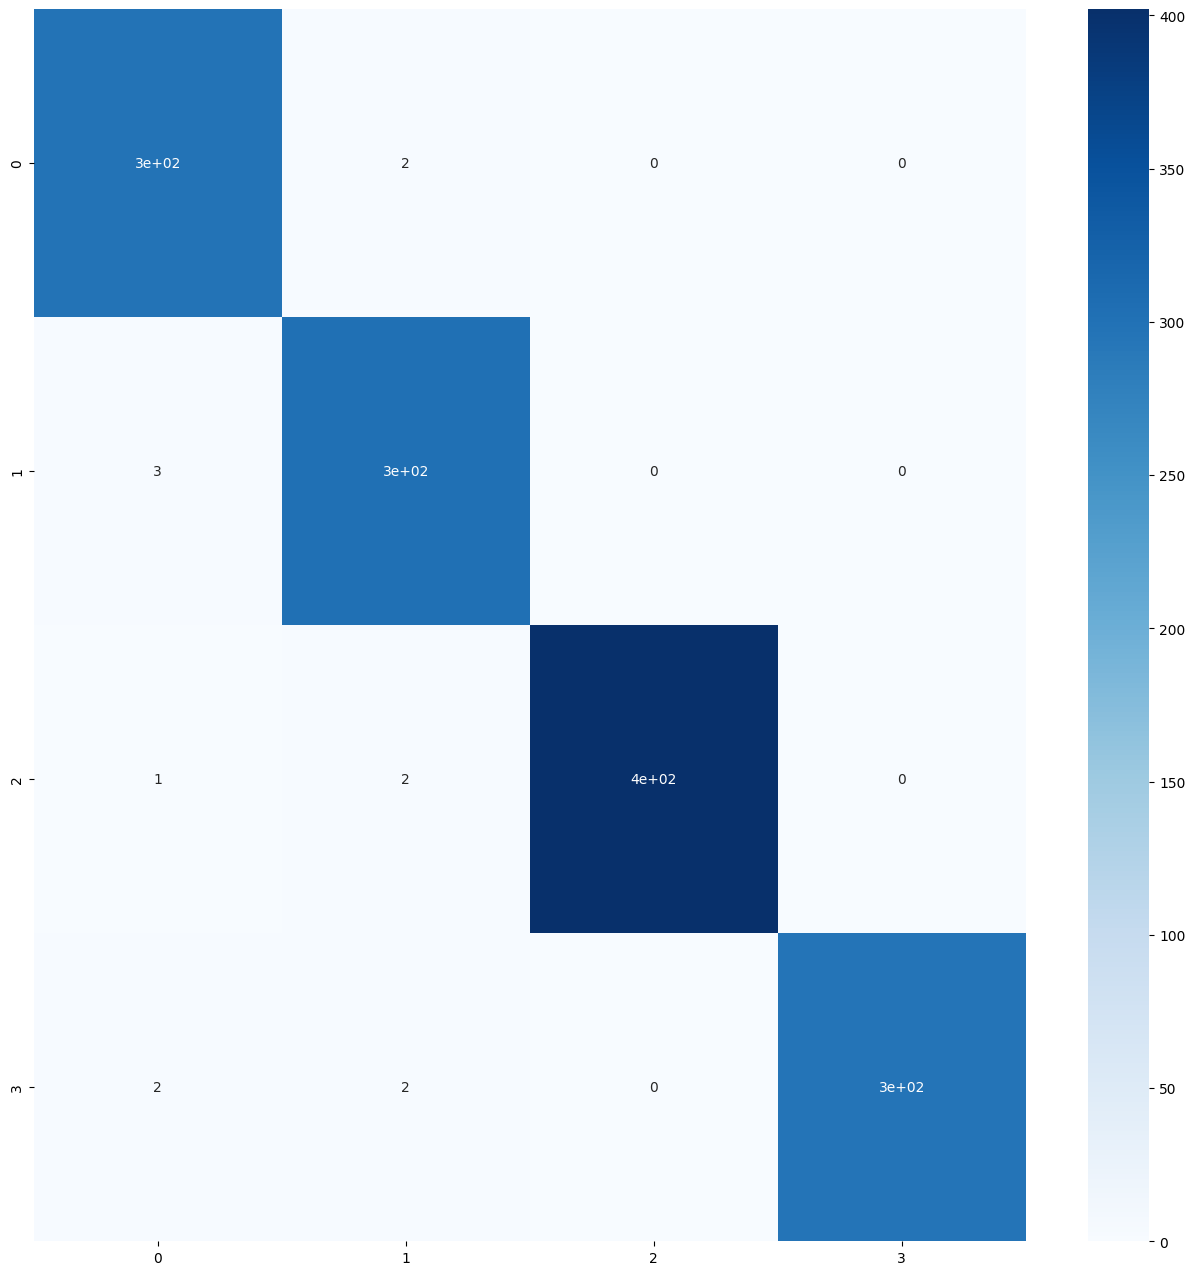

In [ ]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [ ]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 2s 49ms/step - loss: 0.0321 - accuracy: 0.9908


# Load Best Model

In [ ]:
!ls

logs		       model-07-0.98-0.06.h5
model-01-0.23-6.58.h5  model-10-0.99-0.05.h5
model-02-0.24-3.81.h5  model-15-0.99-0.04.h5
model-04-0.76-1.04.h5  resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
model-05-0.97-0.08.h5  run.ipynb


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("model-15-0.99-0.04.h5")


2025-05-01 11:20:12.550485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2025-05-01 11:20:12.551165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10534 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


In [ ]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 3s 51ms/step - loss: 0.0321 - accuracy: 0.9908


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names, figsize=(8, 6), title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                     xticklabels=class_names,
                     yticklabels=class_names)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()



41/41 [==============================] - 2s 48ms/step


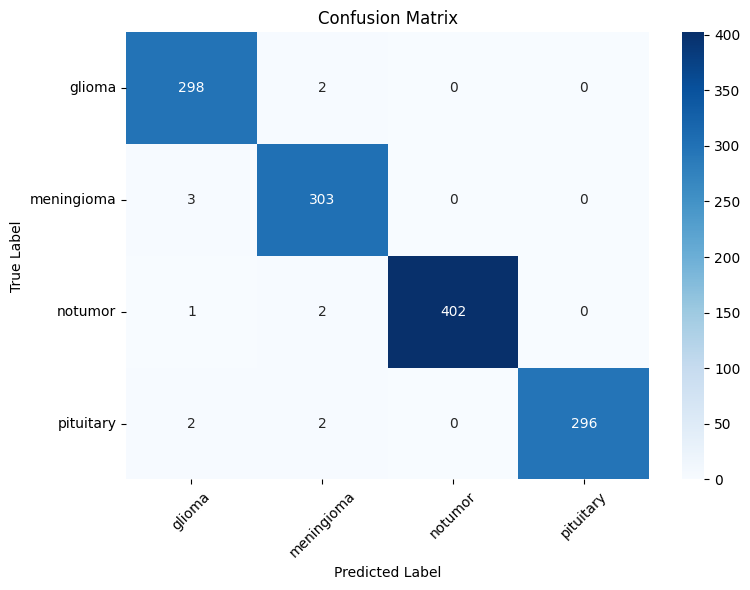

In [ ]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

plot_confusion_matrix(y_true, y_pred, class_names=['glioma', 'meningioma', 'notumor', 'pituitary'])
